In [1]:
import plotly.graph_objects as go
from PIL import Image
import requests
from io import BytesIO #try 1

def show_map(buildings, building_names, building_coordinates, demand, truck_coordinates, placed_trucks = []):
    """displays the Burrito Optimization map with labels for open truck locations, buildings with demand, and placed trucks [optional].  This is intended to be used in the Gurobi Days Intro to Modeling course"""

    y_max = 550

    truck_spot_x = [value[0] for key, value in truck_coordinates.items()]
    truck_spot_y = [y_max - value[1] for key, value in truck_coordinates.items()]
    trucks = [key for key, value in truck_coordinates.items()]

    building_x = [value[0] for key, value in building_coordinates.items()]
    building_y = [y_max - value[1] for key, value in building_coordinates.items()]
    demand = [value for key, value in demand.items()]
    building_names = [value for key, value in building_names.items()]

    if placed_trucks:
        placed_truck_spot_x = [value[0] for key, value in truck_coordinates.items() if key in placed_trucks]
        placed_truck_spot_y = [y_max - value[1] for key, value in truck_coordinates.items() if key in placed_trucks]
        placed_trucks = [key for key, value in truck_coordinates.items() if key in placed_trucks]

    map = Image.open('map.png')
    fig = go.Figure()

    # Add trace for truck spots
    fig.add_trace(
        go.Scatter(x=truck_spot_x, y=truck_spot_y,
                   hovertemplate=trucks,
                   name="Open truck spots",
                   mode='markers',
                   marker_color='rgba(135, 206, 250, 0.0)',
                   marker_line_color='darkblue',
                   marker_line_width=2,
                   marker_size=10
                   )
    )

    # Add trace for placed trucks
    if placed_trucks:
        fig.add_trace(
            go.Scatter(x=placed_truck_spot_x, y=placed_truck_spot_y,
                       hovertemplate=placed_trucks,
                       name="Truck added to the map",
                       mode='markers',
                       marker_color='darkblue',
                       marker_line_color='darkblue',
                       marker_line_width=2,
                       marker_size=10
                       )
        )

    # Add trace for buildings
    fig.add_trace(
        go.Scatter(x=building_x, y=building_y,
                   hovertemplate=building_names,
                   name="Buildings with customer demand",
                   mode='markers',
                   marker_color='red',
                   marker_opacity=0.5,
                   marker_line_width=0,
                   marker_size=demand
                   )
    )

    # Add minimap image
    fig.add_layout_image(
            dict(
                source=map,
                xref="x",
                yref="y",
                x=0,
                y=550,
                sizex=500,
                sizey=550,
                sizing="stretch",
                opacity=0.9,
                layer="below")
    )

    # Set templates
    fig.update_layout(template="simple_white")
    fig.update_xaxes(range=[0, 500], visible=False)
    fig.update_yaxes(range=[0,550], visible=False,
                    scaleanchor = "x",scaleratio = 1)
    fig.update_layout(showlegend=True)

    fig.update_layout(
        title="Burrito Optimization Game Map",
    )

    fig.show()



In [4]:
import os
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
from itertools import product
import time
import numpy as np

def load_multi_period_data(base_path='./Data', days=5):
    all_data = {}
    all_truck_spots = set()
    
    # 首先收集所有可能出现的卡车位置
    for day in range(1, days+1):
        day_folder = f"day_{day}"
        truck_path = f"{base_path}/{day_folder}/round1-day{day}_truck_node_data.csv"
        if os.path.exists(truck_path):
            df_truck = pd.read_csv(truck_path)
            all_truck_spots.update(df_truck['index'].unique())
    
    for day in range(1, days+1):
        day_key = f'day{day}'
        day_data = {}
        day_folder = f"day_{day}"
        # print(f"\n正在加载 {day_key} 数据...")
        
        try:
            # 1. 问题数据
            problem_path = f"{base_path}/{day_folder}/round1-day{day}_problem_data.csv"
            df_problem = pd.read_csv(problem_path)
            day_data.update({
                'burrito_price': float(df_problem['burrito_price'][0]),
                'ingredient_cost': float(df_problem['ingredient_cost'][0]),
                'truck_cost': float(df_problem['truck_cost'][0])
            })
            # print(f"  问题数据加载成功 | 价格: ₲{day_data['burrito_price']} 成本: ₲{day_data['ingredient_cost']}")

            # 2. 卡车位置（使用全集）
            truck_path = f"{base_path}/{day_folder}/round1-day{day}_truck_node_data.csv"
            df_truck = pd.read_csv(truck_path)
            day_data['truck_coordinates'] = {
                spot: (float(df_truck[df_truck['index']==spot]['x'].iloc[0]), 
                      float(df_truck[df_truck['index']==spot]['y'].iloc[0]))
                for spot in all_truck_spots if spot in df_truck['index'].values
            }
            day_data['truck_spots'] = list(all_truck_spots)  # 使用全集
            # print(f"  卡车位置 | 总数: {len(day_data['truck_spots'])} 实际可用: {len(day_data['truck_coordinates'])}")

            # 3. 需求数据
            demand_path = f"{base_path}/{day_folder}/round1-day{day}_demand_node_data.csv"
            df_demand = pd.read_csv(demand_path)
            buildings_data = {
                row['index']: [row['name'], (float(row['x']), float(row['y'])), float(row['demand'])]
                for _, row in df_demand.iterrows()
            }
            day_data['buildings'], day_data['building_names'], day_data['building_coords'], day_data['demand'] = gp.multidict(buildings_data)
            # print(f"  需求节点 | 总数: {len(day_data['buildings'])}")

            # 4. 距离和偏好分数
            pairs_path = f"{base_path}/{day_folder}/round1-day{day}_demand_truck_data.csv"
            df_pairs = pd.read_csv(pairs_path)
            
            # 构建有效对字典
            pairs_dict = {}
            for _, row in df_pairs.iterrows():
                i = row['demand_node_index']
                j = row['truck_node_index']
                if j in all_truck_spots and float(row['scaled_demand']) > 0:
                    pairs_dict[(i,j)] = [float(row['distance']), float(row['scaled_demand'])]
            
            # 安全创建multidict
            if pairs_dict:
                day_data['pairs'], day_data['distance'], day_data['scaled_demand'] = gp.multidict(pairs_dict)
                # print(f"  有效客户-位置对 | 数量: {len(day_data['pairs'])}")
            else:
                day_data['pairs'], day_data['distance'], day_data['scaled_demand'] = [], [], []
                # print("  警告: 未找到有效客户-位置对")
            
            all_data[day_key] = day_data
            
        except Exception as e:
            # print(f"  加载 {day_key} 数据失败: {str(e)}")
            raise
    
    return all_data

# ================== 修正版多周期优化模型 ==================
def multi_period_optimization(data, truck_types, maintenance_cost_ratio=0.2, 
                            max_distance=500, work_name="MultiPeriod", 
                            write_lp=True, show_model=True, is_show_map=True):
    """修正索引错误的优化模型"""
    days = sorted(data.keys())
    model = gp.Model("MultiPeriod_Deployment")
    model.Params.OutputFlag = int(show_model)
    
    # print("\n" + "="*50)
    # print(f"开始构建多周期模型 (共{len(days)}天)")
    # print(f"卡车类型: {len(truck_types)}种 | 最大距离: {max_distance}m")
    # print("="*50 + "\n")
    
    # --- 决策变量 ---
    # print("创建决策变量...")
    start_time = time.time()
    
    # 使用统一的卡车位置全集
    all_truck_spots = set()
    for day_data in data.values():
        all_truck_spots.update(day_data['truck_coordinates'].keys())
    all_truck_spots = list(all_truck_spots)
    
    # x[k,j,t]
    x = model.addVars(
        [(k, j, t) for k in truck_types 
                   for j in all_truck_spots 
                   for t in days],
        vtype=GRB.BINARY, name="x"
    )
    
    # y[i,j,t]
    y = model.addVars(
        [(i, j, t) for t in days 
                   for i,j in data[t]['pairs']],
        vtype=GRB.BINARY, name="y"
    )
    
    # u[k,j,t]
    u = model.addVars(
        [(k, j, t) for k in truck_types 
                   for j in all_truck_spots 
                   for t in days[1:]],
        vtype=GRB.BINARY, name="u"
    )
    
    # print(f"变量创建完成 | 耗时: {time.time()-start_time:.2f}s")
    # print(f"  - 部署变量 x: {len(x)} 个")
    # print(f"  - 服务变量 y: {len(y)} 个")
    # print(f"  - 状态变化变量 u: {len(u)} 个")
    
    # --- 目标函数 ---
    # print("\n构建目标函数...")
    start_time = time.time()
    
    revenue = gp.quicksum(
        (data[t]['burrito_price'] - data[t]['ingredient_cost']) * 
        data[t]['scaled_demand'][i,j] * y[i,j,t]
        for t in days for i,j in data[t]['pairs']
    )
    
    maintenance_cost = gp.quicksum(
        (maintenance_cost_ratio * truck_types[k]['fixed_cost']) * (x[k,j,t] - u[k,j,t])
        for k in truck_types for j in all_truck_spots for t in days[1:]
    )
    
    deployment_cost = gp.quicksum(
        truck_types[k]['fixed_cost'] * u[k,j,t]
        for k in truck_types for j in all_truck_spots for t in days[1:]
    ) + gp.quicksum(
        truck_types[k]['fixed_cost'] * x[k,j,days[0]]
        for k in truck_types for j in all_truck_spots
    )
    
    model.setObjective(revenue - (maintenance_cost + deployment_cost), GRB.MAXIMIZE)
    # print(f"目标函数构建完成 | 耗时: {time.time()-start_time:.2f}s")
    
    # --- 约束条件 ---
    # print("\n构建约束条件...")
    start_time = time.time()
    
    # 状态转移约束（使用更清晰的XOR实现）
    # print("  - 状态转移约束...")
    for k in truck_types:
        for j in all_truck_spots:
            for t in days[1:]:
                prev_day = days[days.index(t)-1]
                # 方法1：使用Gurobi内置XOR（推荐）
                if hasattr(model, 'addGenConstrXor'):
                    model.addGenConstrXor(
                        [x[k,j,t]], [x[k,j,prev_day]], 
                        u[k,j,t],
                        name=f"StateChangeXOR_{k}_{j}_{t}"
                    )
                # 方法2：线性化方法（兼容旧版）
                else:
                    model.addConstr(
                        u[k,j,t] >= x[k,j,t] - x[k,j,prev_day],
                        name=f"StateChange1_{k}_{j}_{t}"
                    )
                    model.addConstr(
                        u[k,j,t] >= x[k,j,prev_day] - x[k,j,t],
                        name=f"StateChange2_{k}_{j}_{t}"
                    )
                    model.addConstr(
                        u[k,j,t] <= x[k,j,t] + x[k,j,prev_day],
                        name=f"StateChange3_{k}_{j}_{t}"
                    )
                    model.addConstr(
                        u[k,j,t] <= 2 - x[k,j,t] - x[k,j,prev_day],
                        name=f"StateChange4_{k}_{j}_{t}"
                    )
    
    # 2. 每日约束
    for t in days:
        # print(f"  - Day {t} 约束...")
        current_truck_spots = set(data[t]['truck_coordinates'].keys())
        
        # 单服务约束
        model.addConstrs(
            (gp.quicksum(y[i,j,t] for j in current_truck_spots if (i,j) in data[t]['pairs']) <= 1
            for i in data[t]['buildings']),
            name=f"SingleService_{t}"
        )
        
        # 服务激活（仅对当前可用的卡车位置）
        model.addConstrs(
            (y[i,j,t] <= gp.quicksum(x[k,j,t] for k in truck_types if j in current_truck_spots)
            for i,j in data[t]['pairs']),
            name=f"Activation_{t}"
        )
        
        # 距离约束
        model.addConstrs(
            (y[i,j,t] * data[t]['distance'][i,j] <= max_distance
            for i,j in data[t]['pairs']),
            name=f"Distance_{t}"
        )
        
        # 容量约束（仅对当前可用的卡车位置）
        model.addConstrs(
            (gp.quicksum(
                data[t]['scaled_demand'][i,j] * y[i,j,t] 
                for i in data[t]['buildings'] if (i,j) in data[t]['pairs']
            ) <= gp.quicksum(
                truck_types[k]['capacity'] * x[k,j,t] 
                for k in truck_types if j in current_truck_spots
            ) for j in current_truck_spots),
            name=f"Capacity_{t}"
        )
        
        # 卡车类型唯一性
        model.addConstrs(
            (gp.quicksum(x[k,j,t] for k in truck_types if j in current_truck_spots) <= 1
            for j in current_truck_spots),
            name=f"Uniqueness_{t}"
        )
    
    # print(f"约束构建完成 | 总约束数: {model.NumConstrs} | 耗时: {time.time()-start_time:.2f}s")
    
    # --- 模型求解 ---
    if write_lp:
        print("\n写入LP文件...")
        model.write(f"{work_name}.lp")
    
    # print("\n开始求解...")
    start_time = time.time()
    model.optimize()
    # print(f"求解完成 | 状态: {model.status} | 耗时: {time.time()-start_time:.2f}s")
    
    # ================== 修正后的结果分析部分 ==================
    if model.status == GRB.OPTIMAL:
        # print("\n" + "="*50)
        # print(f"最优解结果 (总利润: ₲{model.objVal:.2f})")
        # print("="*50)

        for t in days:
            current_truck_spots = set(data[t]['truck_coordinates'].keys())
            # print(f"\nDay {t}:")

            # 部署统计
            deployed = [(k,j) for k,j,_ in x.keys() 
                       if x[k,j,t].X > 0.5 and j in current_truck_spots and _ == t]

            # 修正点：单独处理day1的情况
            if t == days[0]:  # 第一天
                new_deploy = [j for k,j in deployed]  # 所有都是新增
                deploy_status = "新增"
            else:  # 第二天及以后
                prev_day = days[days.index(t)-1]
                new_deploy = [j for k,j in deployed 
                             if x[k,j,prev_day].X < 0.5]
                deploy_status = f"{len(new_deploy)}新增, {len(deployed)-len(new_deploy)}维护"

            # print(f"  - 部署卡车: {len(deployed)} 辆 ({deploy_status})")
            for k,j in deployed:
                # 修正点：准确判断状态
                status = "新增" if (t == days[0] or j in new_deploy) else "维护"
                typ = ['Small','Medium','Large'][k]
                # print(f"    * 位置 {j}: {typ} ({status})")
            
            # 可视化
            if is_show_map:
                placed_trucks = [j for k,j,_ in x.keys() 
                               if x[k,j,t].X > 0.5 and _ == t and j in current_truck_spots]
                show_map(
                    data[t]['buildings'], data[t]['building_names'],
                    data[t]['building_coords'], data[t]['demand'],
                    data[t]['truck_coordinates'], placed_trucks
                )
    
    return model


In [ ]:
data_list = []

truck_types = {
        0: {'capacity': 100, 'fixed_cost': 200, 'maintenance_cost': 40},  # Small
        1: {'capacity': 150, 'fixed_cost': 250, 'maintenance_cost': 50},  # Medium
        2: {'capacity': 200, 'fixed_cost': 300, 'maintenance_cost': 60}   # Large
    }

for max_distance in np.arange(50,500,50):
    # Read data in files
    data = load_multi_period_data(base_path='./Data', days=5)

    for ratio in np.arange(0.2, 0.8, 0.1):
        # solve the linear programming
        model = multi_period_optimization(data, truck_types, maintenance_cost_ratio=ratio, 
                            max_distance=max_distance, work_name="MultiPeriod", 
                            write_lp=False, show_model=False, is_show_map=False)
        optimal_value = model.objVal
        # store the optimal value in dictionary
        data_list.append([max_distance,optimal_value,ratio])


Loading day1 data...
  Problem data loaded successfully | Price: ₲10.0 Cost: ₲5.0
  Truck locations | Total: 56 Actually available: 15
  Demand nodes | Total: 15
  Valid customer-location pairs | Count: 100

Loading day2 data...
  Problem data loaded successfully | Price: ₲10.0 Cost: ₲5.0
  Truck locations | Total: 56 Actually available: 20
  Demand nodes | Total: 29
  Valid customer-location pairs | Count: 275

Loading day3 data...
  Problem data loaded successfully | Price: ₲10.0 Cost: ₲7.0
  Truck locations | Total: 56 Actually available: 20
  Demand nodes | Total: 29
  Valid customer-location pairs | Count: 273

Loading day4 data...
  Problem data loaded successfully | Price: ₲10.0 Cost: ₲5.0
  Truck locations | Total: 56 Actually available: 20
  Demand nodes | Total: 29
  Valid customer-location pairs | Count: 43

Loading day5 data...
  Problem data loaded successfully | Price: ₲10.0 Cost: ₲5.0
  Truck locations | Total: 56 Actually available: 56
  Demand nodes | Total: 54
  Vali

Constraints built | Total constraints: 0 | Time: 0.69s

Start solving...
Solving completed | Status: 2 | Time: 0.05s

Optimal solution (Total profit: ₲-0.00)

Day day1:
  - Deployed trucks: 0 (New)
  - Deployed trucks: 0 (New)
  - Daily profit: ₲0.00 (Revenue: ₲0.00, Cost: ₲0.00)

Day day2:
  - Deployed trucks: 0 (0 new, 0 maintained)
  - Deployed trucks: 0 (0 new, 0 maintained)
  - Daily profit: ₲0.00 (Revenue: ₲0.00, Cost: ₲0.00)

Day day3:
  - Deployed trucks: 0 (0 new, 0 maintained)
  - Deployed trucks: 0 (0 new, 0 maintained)
  - Daily profit: ₲0.00 (Revenue: ₲0.00, Cost: ₲0.00)

Day day4:
  - Deployed trucks: 0 (0 new, 0 maintained)
  - Deployed trucks: 0 (0 new, 0 maintained)
  - Daily profit: ₲0.00 (Revenue: ₲0.00, Cost: ₲0.00)

Day day5:
  - Deployed trucks: 0 (0 new, 0 maintained)
  - Deployed trucks: 0 (0 new, 0 maintained)
  - Daily profit: ₲0.00 (Revenue: ₲0.00, Cost: ₲0.00)

Starting to build multi-period model (Total 5 days)
Truck types: 3 | Max distance: 50m

Creating d

Objective function built | Time: 0.08s

Building constraints...
  - State transition constraints...
  - Day day1 constraints...
  - Day day2 constraints...
  - Day day3 constraints...
  - Day day4 constraints...
  - Day day5 constraints...
Constraints built | Total constraints: 0 | Time: 0.72s

Start solving...
Solving completed | Status: 2 | Time: 0.26s

Optimal solution (Total profit: ₲9635.00)

Day day1:
  - Deployed trucks: 1 (New)
  - Deployed trucks: 1 (New)
  - Daily profit: ₲0.00 (Revenue: ₲200.00, Cost: ₲200.00)
    * Location truck37: Small (New)

Day day2:
  - Deployed trucks: 6 (5 new, 1 maintained)
  - Deployed trucks: 6 (5 new, 1 maintained)
  - Daily profit: ₲1465.00 (Revenue: ₲2625.00, Cost: ₲1160.00)
    * Location truck45: Small (New)
    * Location truck8: Small (New)
    * Location truck37: Small (Maintained)
    * Location truck15: Small (New)
    * Location truck53: Medium (New)
    * Location truck33: Medium (New)

Day day3:
  - Deployed trucks: 6 (0 new, 6 maint

  - Day day1 constraints...
  - Day day2 constraints...
  - Day day3 constraints...
  - Day day4 constraints...
  - Day day5 constraints...
Constraints built | Total constraints: 0 | Time: 0.73s

Start solving...
Solving completed | Status: 2 | Time: 0.17s

Optimal solution (Total profit: ₲8435.00)

Day day1:
  - Deployed trucks: 1 (New)
  - Deployed trucks: 1 (New)
  - Daily profit: ₲0.00 (Revenue: ₲200.00, Cost: ₲200.00)
    * Location truck37: Small (New)

Day day2:
  - Deployed trucks: 6 (5 new, 1 maintained)
  - Deployed trucks: 6 (5 new, 1 maintained)
  - Daily profit: ₲1405.00 (Revenue: ₲2625.00, Cost: ₲1220.00)
    * Location truck45: Small (New)
    * Location truck8: Small (New)
    * Location truck37: Small (Maintained)
    * Location truck15: Small (New)
    * Location truck53: Medium (New)
    * Location truck33: Medium (New)

Day day3:
  - Deployed trucks: 5 (0 new, 5 maintained)
  - Deployed trucks: 5 (0 new, 5 maintained)
  - Daily profit: ₲520.00 (Revenue: ₲1260.00, Co

  Demand nodes | Total: 29
  Valid customer-location pairs | Count: 275

Loading day3 data...
  Problem data loaded successfully | Price: ₲10.0 Cost: ₲7.0
  Truck locations | Total: 56 Actually available: 20
  Demand nodes | Total: 29
  Valid customer-location pairs | Count: 273

Loading day4 data...
  Problem data loaded successfully | Price: ₲10.0 Cost: ₲5.0
  Truck locations | Total: 56 Actually available: 20
  Demand nodes | Total: 29
  Valid customer-location pairs | Count: 43

Loading day5 data...
  Problem data loaded successfully | Price: ₲10.0 Cost: ₲5.0
  Truck locations | Total: 56 Actually available: 56
  Demand nodes | Total: 54
  Valid customer-location pairs | Count: 1055

Starting to build multi-period model (Total 5 days)
Truck types: 3 | Max distance: 150m

Creating decision variables...
Variables created | Time: 0.04s
  - Deployment variables x: 840
  - Service variables y: 1746
  - State change variables u: 672

Building objective function...
Objective function buil

  - Day day1 constraints...
  - Day day2 constraints...
  - Day day3 constraints...
  - Day day4 constraints...
  - Day day5 constraints...
Constraints built | Total constraints: 0 | Time: 0.71s

Start solving...
Solving completed | Status: 2 | Time: 1.74s

Optimal solution (Total profit: ₲15084.00)

Day day1:
  - Deployed trucks: 4 (New)
  - Deployed trucks: 4 (New)
  - Daily profit: ₲-90.00 (Revenue: ₲860.00, Cost: ₲950.00)
    * Location truck8: Small (New)
    * Location truck37: Small (New)
    * Location truck17: Medium (New)
    * Location truck33: Large (New)

Day day2:
  - Deployed trucks: 9 (5 new, 4 maintained)
  - Deployed trucks: 9 (5 new, 4 maintained)
  - Daily profit: ₲3085.00 (Revenue: ₲4715.00, Cost: ₲1630.00)
    * Location truck29: Small (New)
    * Location truck8: Small (Maintained)
    * Location truck37: Small (Maintained)
    * Location truck23: Medium (New)
    * Location truck17: Medium (Maintained)
    * Location truck15: Medium (New)
    * Location truck44:

  - Day day1 constraints...
  - Day day2 constraints...
  - Day day3 constraints...
  - Day day4 constraints...
  - Day day5 constraints...
Constraints built | Total constraints: 0 | Time: 0.88s

Start solving...
Solving completed | Status: 2 | Time: 0.82s

Optimal solution (Total profit: ₲12907.00)

Day day1:
  - Deployed trucks: 3 (New)
  - Deployed trucks: 3 (New)
  - Daily profit: ₲20.00 (Revenue: ₲720.00, Cost: ₲700.00)
    * Location truck37: Small (New)
    * Location truck17: Small (New)
    * Location truck33: Large (New)

Day day2:
  - Deployed trucks: 8 (5 new, 3 maintained)
  - Deployed trucks: 8 (5 new, 3 maintained)
  - Daily profit: ₲2700.00 (Revenue: ₲4390.00, Cost: ₲1690.00)
    * Location truck8: Small (New)
    * Location truck37: Small (Maintained)
    * Location truck17: Small (Maintained)
    * Location truck45: Medium (New)
    * Location truck23: Medium (New)
    * Location truck15: Medium (New)
    * Location truck44: Medium (New)
    * Location truck33: Large 

Objective function built | Time: 0.07s

Building constraints...
  - State transition constraints...
  - Day day1 constraints...
  - Day day2 constraints...
  - Day day3 constraints...
  - Day day4 constraints...
  - Day day5 constraints...
Constraints built | Total constraints: 0 | Time: 0.62s

Start solving...
Solving completed | Status: 2 | Time: 1.99s

Optimal solution (Total profit: ₲17982.00)

Day day1:
  - Deployed trucks: 4 (New)
  - Deployed trucks: 4 (New)
  - Daily profit: ₲600.00 (Revenue: ₲1550.00, Cost: ₲950.00)
    * Location truck8: Small (New)
    * Location truck37: Small (New)
    * Location truck17: Medium (New)
    * Location truck33: Large (New)

Day day2:
  - Deployed trucks: 8 (4 new, 4 maintained)
  - Deployed trucks: 8 (4 new, 4 maintained)
  - Daily profit: ₲3955.00 (Revenue: ₲5290.00, Cost: ₲1335.00)
    * Location truck29: Small (New)
    * Location truck8: Small (Maintained)
    * Location truck37: Small (Maintained)
    * Location truck23: Medium (New)
   

Objective function built | Time: 0.07s

Building constraints...
  - State transition constraints...
  - Day day1 constraints...
  - Day day2 constraints...
  - Day day3 constraints...
  - Day day4 constraints...
  - Day day5 constraints...
Constraints built | Total constraints: 0 | Time: 0.59s

Start solving...
Solving completed | Status: 2 | Time: 1.41s

Optimal solution (Total profit: ₲15805.00)

Day day1:
  - Deployed trucks: 4 (New)
  - Deployed trucks: 4 (New)
  - Daily profit: ₲600.00 (Revenue: ₲1550.00, Cost: ₲950.00)
    * Location truck8: Small (New)
    * Location truck37: Small (New)
    * Location truck17: Medium (New)
    * Location truck33: Large (New)

Day day2:
  - Deployed trucks: 8 (4 new, 4 maintained)
  - Deployed trucks: 8 (4 new, 4 maintained)
  - Daily profit: ₲3720.00 (Revenue: ₲5290.00, Cost: ₲1570.00)
    * Location truck29: Small (New)
    * Location truck23: Small (New)
    * Location truck8: Small (Maintained)
    * Location truck37: Small (Maintained)
    

  Valid customer-location pairs | Count: 100

Loading day2 data...
  Problem data loaded successfully | Price: ₲10.0 Cost: ₲5.0
  Truck locations | Total: 56 Actually available: 20
  Demand nodes | Total: 29
  Valid customer-location pairs | Count: 275

Loading day3 data...
  Problem data loaded successfully | Price: ₲10.0 Cost: ₲7.0
  Truck locations | Total: 56 Actually available: 20
  Demand nodes | Total: 29
  Valid customer-location pairs | Count: 273

Loading day4 data...
  Problem data loaded successfully | Price: ₲10.0 Cost: ₲5.0
  Truck locations | Total: 56 Actually available: 20
  Demand nodes | Total: 29
  Valid customer-location pairs | Count: 43

Loading day5 data...
  Problem data loaded successfully | Price: ₲10.0 Cost: ₲5.0
  Truck locations | Total: 56 Actually available: 56
  Demand nodes | Total: 54
  Valid customer-location pairs | Count: 1055

Starting to build multi-period model (Total 5 days)
Truck types: 3 | Max distance: 250m

Creating decision variables...
Va

  - Day day1 constraints...
  - Day day2 constraints...
  - Day day3 constraints...
  - Day day4 constraints...
  - Day day5 constraints...
Constraints built | Total constraints: 0 | Time: 0.74s

Start solving...
Solving completed | Status: 2 | Time: 2.80s

Optimal solution (Total profit: ₲17265.00)

Day day1:
  - Deployed trucks: 4 (New)
  - Deployed trucks: 4 (New)
  - Daily profit: ₲610.00 (Revenue: ₲1560.00, Cost: ₲950.00)
    * Location truck8: Small (New)
    * Location truck37: Small (New)
    * Location truck17: Medium (New)
    * Location truck33: Large (New)

Day day2:
  - Deployed trucks: 8 (4 new, 4 maintained)
  - Deployed trucks: 8 (4 new, 4 maintained)
  - Daily profit: ₲3910.00 (Revenue: ₲5290.00, Cost: ₲1380.00)
    * Location truck29: Small (New)
    * Location truck23: Small (New)
    * Location truck8: Small (Maintained)
    * Location truck37: Small (Maintained)
    * Location truck17: Medium (Maintained)
    * Location truck33: Large (Maintained)
    * Location tr

Objective function built | Time: 0.07s

Building constraints...
  - State transition constraints...
  - Day day1 constraints...
  - Day day2 constraints...
  - Day day3 constraints...
  - Day day4 constraints...
  - Day day5 constraints...
Constraints built | Total constraints: 0 | Time: 0.73s

Start solving...
Solving completed | Status: 2 | Time: 6.08s

Optimal solution (Total profit: ₲15150.00)

Day day1:
  - Deployed trucks: 4 (New)
  - Deployed trucks: 4 (New)
  - Daily profit: ₲660.00 (Revenue: ₲1560.00, Cost: ₲900.00)
    * Location truck8: Small (New)
    * Location truck37: Small (New)
    * Location truck33: Medium (New)
    * Location truck17: Medium (New)

Day day2:
  - Deployed trucks: 8 (4 new, 4 maintained)
  - Deployed trucks: 8 (4 new, 4 maintained)
  - Daily profit: ₲3575.00 (Revenue: ₲5205.00, Cost: ₲1630.00)
    * Location truck29: Small (New)
    * Location truck23: Small (New)
    * Location truck8: Small (Maintained)
    * Location truck37: Small (Maintained)
   

Constraints built | Total constraints: 0 | Time: 0.72s

Start solving...
Solving completed | Status: 2 | Time: 2.52s

Optimal solution (Total profit: ₲18762.00)

Day day1:
  - Deployed trucks: 4 (New)
  - Deployed trucks: 4 (New)
  - Daily profit: ₲560.00 (Revenue: ₲1560.00, Cost: ₲1000.00)
    * Location truck8: Small (New)
    * Location truck37: Medium (New)
    * Location truck17: Medium (New)
    * Location truck33: Large (New)

Day day2:
  - Deployed trucks: 8 (4 new, 4 maintained)
  - Deployed trucks: 8 (4 new, 4 maintained)
  - Daily profit: ₲4150.00 (Revenue: ₲5350.00, Cost: ₲1200.00)
    * Location truck29: Small (New)
    * Location truck8: Small (Maintained)
    * Location truck45: Medium (New)
    * Location truck23: Medium (New)
    * Location truck37: Medium (Maintained)
    * Location truck17: Medium (Maintained)
    * Location truck33: Large (Maintained)
    * Location truck15: Large (New)

Day day3:
  - Deployed trucks: 9 (1 new, 8 maintained)
  - Deployed trucks: 9 (

Objective function built | Time: 0.07s

Building constraints...
  - State transition constraints...
  - Day day1 constraints...
  - Day day2 constraints...
  - Day day3 constraints...
  - Day day4 constraints...
  - Day day5 constraints...
Constraints built | Total constraints: 0 | Time: 0.64s

Start solving...
Solving completed | Status: 2 | Time: 2.13s

Optimal solution (Total profit: ₲16560.00)

Day day1:
  - Deployed trucks: 4 (New)
  - Deployed trucks: 4 (New)
  - Daily profit: ₲660.00 (Revenue: ₲1560.00, Cost: ₲900.00)
    * Location truck8: Small (New)
    * Location truck37: Small (New)
    * Location truck33: Medium (New)
    * Location truck17: Medium (New)

Day day2:
  - Deployed trucks: 8 (4 new, 4 maintained)
  - Deployed trucks: 8 (4 new, 4 maintained)
  - Daily profit: ₲3755.00 (Revenue: ₲5205.00, Cost: ₲1450.00)
    * Location truck29: Small (New)
    * Location truck23: Small (New)
    * Location truck8: Small (Maintained)
    * Location truck37: Small (Maintained)
   

  - Day day1 constraints...
  - Day day2 constraints...
  - Day day3 constraints...
  - Day day4 constraints...
  - Day day5 constraints...
Constraints built | Total constraints: 0 | Time: 0.60s

Start solving...
Solving completed | Status: 2 | Time: 12.21s

Optimal solution (Total profit: ₲14520.00)

Day day1:
  - Deployed trucks: 4 (New)
  - Deployed trucks: 4 (New)
  - Daily profit: ₲560.00 (Revenue: ₲1560.00, Cost: ₲1000.00)
    * Location truck8: Small (New)
    * Location truck33: Medium (New)
    * Location truck37: Medium (New)
    * Location truck17: Large (New)

Day day2:
  - Deployed trucks: 7 (3 new, 4 maintained)
  - Deployed trucks: 7 (3 new, 4 maintained)
  - Daily profit: ₲3545.00 (Revenue: ₲5145.00, Cost: ₲1600.00)
    * Location truck8: Small (Maintained)
    * Location truck33: Medium (Maintained)
    * Location truck23: Medium (New)
    * Location truck37: Medium (Maintained)
    * Location truck15: Medium (New)
    * Location truck45: Large (New)
    * Location tru

Solving completed | Status: 2 | Time: 2.95s

Optimal solution (Total profit: ₲17997.00)

Day day1:
  - Deployed trucks: 4 (New)
  - Deployed trucks: 4 (New)
  - Daily profit: ₲560.00 (Revenue: ₲1560.00, Cost: ₲1000.00)
    * Location truck8: Small (New)
    * Location truck37: Medium (New)
    * Location truck17: Medium (New)
    * Location truck33: Large (New)

Day day2:
  - Deployed trucks: 8 (4 new, 4 maintained)
  - Deployed trucks: 8 (4 new, 4 maintained)
  - Daily profit: ₲4050.00 (Revenue: ₲5350.00, Cost: ₲1300.00)
    * Location truck29: Small (New)
    * Location truck8: Small (Maintained)
    * Location truck45: Medium (New)
    * Location truck23: Medium (New)
    * Location truck37: Medium (Maintained)
    * Location truck17: Medium (Maintained)
    * Location truck33: Large (Maintained)
    * Location truck15: Large (New)

Day day3:
  - Deployed trucks: 9 (1 new, 8 maintained)
  - Deployed trucks: 9 (1 new, 8 maintained)
  - Daily profit: ₲2332.00 (Revenue: ₲3132.00, Cost:

Objective function built | Time: 0.08s

Building constraints...
  - State transition constraints...
  - Day day1 constraints...
  - Day day2 constraints...
  - Day day3 constraints...
  - Day day4 constraints...
  - Day day5 constraints...
Constraints built | Total constraints: 0 | Time: 0.72s

Start solving...
Solving completed | Status: 2 | Time: 3.70s

Optimal solution (Total profit: ₲15855.00)

Day day1:
  - Deployed trucks: 4 (New)
  - Deployed trucks: 4 (New)
  - Daily profit: ₲660.00 (Revenue: ₲1560.00, Cost: ₲900.00)
    * Location truck8: Small (New)
    * Location truck37: Small (New)
    * Location truck33: Medium (New)
    * Location truck17: Medium (New)

Day day2:
  - Deployed trucks: 8 (4 new, 4 maintained)
  - Deployed trucks: 8 (4 new, 4 maintained)
  - Daily profit: ₲3665.00 (Revenue: ₲5205.00, Cost: ₲1540.00)
    * Location truck29: Small (New)
    * Location truck23: Small (New)
    * Location truck8: Small (Maintained)
    * Location truck37: Small (Maintained)
   

  Valid customer-location pairs | Count: 100

Loading day2 data...
  Problem data loaded successfully | Price: ₲10.0 Cost: ₲5.0
  Truck locations | Total: 56 Actually available: 20
  Demand nodes | Total: 29
  Valid customer-location pairs | Count: 275

Loading day3 data...
  Problem data loaded successfully | Price: ₲10.0 Cost: ₲7.0
  Truck locations | Total: 56 Actually available: 20
  Demand nodes | Total: 29
  Valid customer-location pairs | Count: 273

Loading day4 data...
  Problem data loaded successfully | Price: ₲10.0 Cost: ₲5.0
  Truck locations | Total: 56 Actually available: 20
  Demand nodes | Total: 29
  Valid customer-location pairs | Count: 43

Loading day5 data...
  Problem data loaded successfully | Price: ₲10.0 Cost: ₲5.0
  Truck locations | Total: 56 Actually available: 56
  Demand nodes | Total: 54
  Valid customer-location pairs | Count: 1055

Starting to build multi-period model (Total 5 days)
Truck types: 3 | Max distance: 400m

Creating decision variables...
Va

In [4]:
df_maintenance_cost = pd.DataFrame(data_list, columns=['maximum_distance', 'optimal_value', 'maintenance_cost_ratio'])

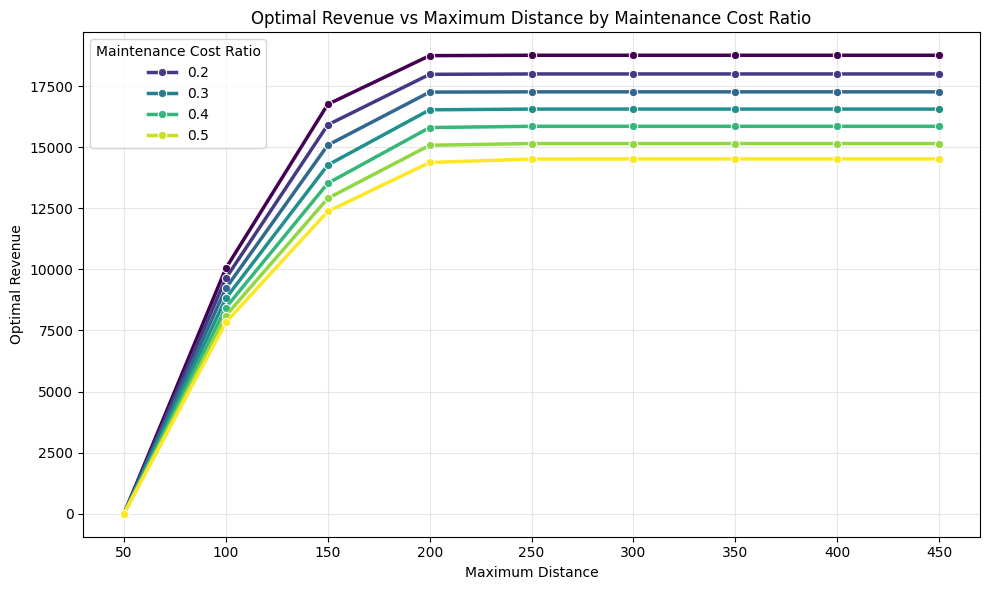

In [9]:
# make the line graph, lines represent different maintenance cost ratio
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# 使用seaborn的lineplot，hue参数自动区分不同maintenance cost ratio
plot = sns.lineplot(
    data=df_maintenance_cost,
    x='maximum_distance',
    y='optimal_value',
    hue='maintenance_cost_ratio',
    marker='o',
    palette='viridis', 
    linewidth=2.5
)


# 获取图例句柄和标签
handles, labels = plot.get_legend_handles_labels()

# 指定你想要显示的标签（按实际值）
plt.legend(handles, ['0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8'], title='Maintenance Cost Ratio')
plt.title('Optimal Revenue vs Maximum Distance by Maintenance Cost Ratio')
plt.xlabel('Maximum Distance')
plt.ylabel('Optimal Revenue')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()